# Tensorflow NLP

This notebook is part of a series of notebooks in this [github repo](https://github.com/nicholasjhana/tensorflow-certification-study-guide) that help prepare for the Tensorflow Certification. Feel free to check out the other notebooks too!

1. [Tensorflow: Guide to Getting Started](https://www.kaggle.com/nicholasjhana/tensorflow-getting-started/edit/run/46189040)
2. [TensorFlow: Multi-Class Image Classification With Transfer Learning](https://www.kaggle.com/nicholasjhana/tensorflow-multi-classification-transfer-learning)
3. [Tensorflow: NLP] (https://www.kaggle.com/nicholasjhana/tensorflow-nlp)
4. [Multi-Variate Time Series Forecasting Tensorflow](https://www.kaggle.com/nicholasjhana/multi-variate-time-series-forecasting-tensorflow)

## TensorFlow Concepts
This notebook covers the following topics from the tensorflow certification handbook:
- Prepare text for use in a TensorFlow model
- Use TensorFlow to identify text in binary categorization.
- Use RNNs, LSTMs, and GRUs
- Train word embeddings and import word embedding weights

## Contents
1. [Introduction](#introduction)
2. [NLP Preprocessing](#NLP-Preprocessing)
    - [Tokenizer](#Tokenizer)
    - [Padding](#Padding)
    - [Truncating](#Truncating)
3. [Embeddings](#embeddings)
    - [Using Pretrained Embeddings](#pretrained-embeddings)
4. [Sequential Layers](#sequential-layers)
    - [GRU & LSTM](#gru-lstm)
    - [Bidirectional](#bidirectional)
5. [Summary](#summary)



## References

1. [Do pretrained embeddings give you the extra edge?](https://www.kaggle.com/sbongo/do-pretrained-embeddings-give-you-the-extra-edge)
2. [How to use word embedding layers - Machine Learning Mastery](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)
3. [TensorFlow Tutorial: Word2Vec](https://www.tensorflow.org/tutorials/text/word2vec)
4. [TensorFlow Tutorial: Using the embedding layer](https://www.tensorflow.org/tutorials/text/word_embeddings#using_the_embedding_layer)
5. [Illustrated Guide to LSTMs and GRUs](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)
6. [Illustradted Guide to Recurrent Nerual Networks](https://towardsdatascience.com/illustrated-guide-to-recurrent-neural-networks-79e5eb8049c9)
7. [Birectional LSTM](http://ling.snu.ac.kr/class/cl_under1801/BidirectionalLSTM.pdf)

<a id="introduction"></a>
# Introduction

This notebook uses the Quora Insincere Question dataset where the task is to detect insincere questions from sincere questions. The dataset contains 1.3M question and target pairs that form the classification problem.

Taking a quick inital look at the data we notice it is not balanced. There are many more sincere questions to insincere. We also notice that the average and most frequent question length is significantly shorter than the longest. So we have a highly skewed distribution and this will influence how we choose the maximum length in our preprocessing.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

In [ ]:
train = pd.read_csv("../input/quora-insincere-questions-classification/train.csv")
test = pd.read_csv("../input/quora-insincere-questions-classification/test.csv")
ss = pd.read_csv("../input/quora-insincere-questions-classification/sample_submission.csv")
train.question_text = train.question_text.astype("str")
train.info()

In [ ]:
train.head()

In [ ]:
train.target.value_counts().plot(kind='bar', title="Count of target label")

In [ ]:
print(f"Maximum sequence length: {train.question_text.apply(len).max()}")
print(f"Most frequent sequence length: {train.question_text.apply(len).mode()[0]}")
print(f"Mean sequence length: {train.question_text.apply(len).mean()}")

In [ ]:
train.question_text.apply(len).plot(kind='hist', bins=50, title="Histogram of question length")

<a id="NLP-Preprocessing"></a>
# NLP Preprocessing
Using text data with neural networks requires special preprocessing in order to prepare the data for modelling. Specifically we'll need to convert the text to a numerical representation, and to standardize this representation. We can do this by building a word vocabulary with a tokenizer, and by padding the sequences to standardize their length.

<a id="Tokenizer"></a>
## Tokenizer
Tokenization is the process ot converting sentences, phrases, words, or characters into unique ids. The unique ids are then used to represent the text in the model. The process of tokenizing is two steps. First we create the token dictionary of unique entries. And second, we create a text representation where the uniqe ids are assigned based on the frequency of occurance.

We can tokenize a word corpus with `tf.keras.preprocessing.text.Tokenizer` and create a vocbulary using the the `fit_on_texts` method. When initalizing the `Tokenizer` there are arguments that help shape the vocabulary.
- `num_words`: Will set the total number of words in the voaculary based on the most frequent. I.e. if set to 5000 the vocabulary will contain the 5000 most frequent words.
- `oov_token`: This is the text representation given to words that are outside the vocabulary. 
- `filters`: These can be punctuation, special characters, and anything the vocabulary should ignore.

By default the vocublary will return out of vocabulary words at index 0, followed by the most frequently occuring words.

We can view the vocabulary dictionary with the `word_index` method and also the word counts with the `word_counts`. The article [Hands-on NLP Deep Learning Model Preparation in TensorFlow 2.X](https://towardsdatascience.com/hands-on-nlp-deep-learning-model-preparation-in-tensorflow-2-x-2e8c9f3c7633) has a detailed discussion on Tokenization and how its used in TensorFlow 2.0.

<a id="Padding"></a>
## Padding
When talking about sentences, not all sentences are the same length, and yet when we pass the vector to the neural network they will have to all match a certain input shape.In natural language processing like computer vision, padding is the process of filling a vector with zero values to manipulate it's shape. By padding we add zeros "pre" to the beginning of the sentence or "post" to the end of the sentence to fill the missing values that are needed to make the sentence the same lenght.

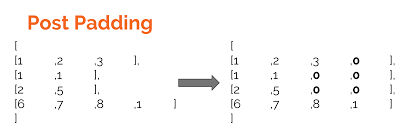
[Source](https://arxiv.org/pdf/1903.07288.pdf)


We can pad our sequences with `tf.keras.preprocessing.sequence.pad_sequnces`. By default it will set the maximum sequence length as the longest sequence in the set. This value can also be modified using the `maxlen` argument. 

<a id="Truncating"></a>
### Truncating
Truncation occurs when a sequence is longer than `maxlen` and part of the sequence must be dropped. By default the `truncating` argument is set to "pre" meaning it will drop the part of the sequence at the beginning that is longer than `maxlen`. Depending on the lanauge and use case this might be desireable, however in english the standard practice is to set `truncating` "post".

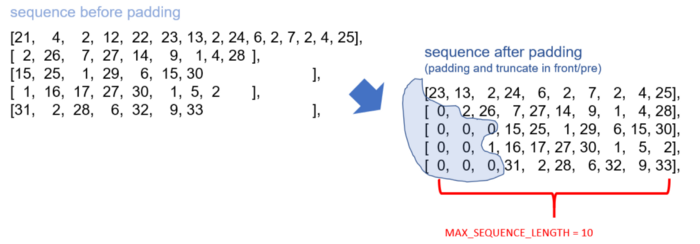
[Source](https://towardsdatascience.com/hands-on-nlp-deep-learning-model-preparation-in-tensorflow-2-x-2e8c9f3c7633)

In [ ]:
#set maxlen based on right edge of question length histogram 
maxlen = 250

#arbitrary choice of top 25000 words
max_features=25000

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features, 
                                                  oov_token="<oov>", 
                                                  filters='"!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n"',
                                                  split=" ")

tokenizer.fit_on_texts(train.question_text)
train_df = tokenizer.texts_to_sequences(train.question_text)
train_df = tf.keras.preprocessing.sequence.pad_sequences(train_df, maxlen=maxlen, padding="post", truncating='post')

In [ ]:
#create a small 100k training sample and 5k validation sample
train_len = int(train_df.shape[0] * 0.1)

X_train = train_df[:train_len]
Y_train = train.target[:train_len]

X_val = train_df[train_len:train_len+5000]
Y_val = train.target[train_len:train_len+5000]

In [ ]:
#balance data on train set
rus = RandomUnderSampler(random_state=42)
X_balance, Y_balance = rus.fit_resample(X_train, Y_train.values)

<a id="embeddings"></a>
# Embeddings

Embeddings are a way of representing words as a vector in such a way that similar words will have similar vector representations. The embedding is created in a many dimensional space (GloVe for examle is available in 50, 100, and 200 dimensions). To conceptualize the idea of an embedding we can think of word pairs we see relationships like that in the image below.

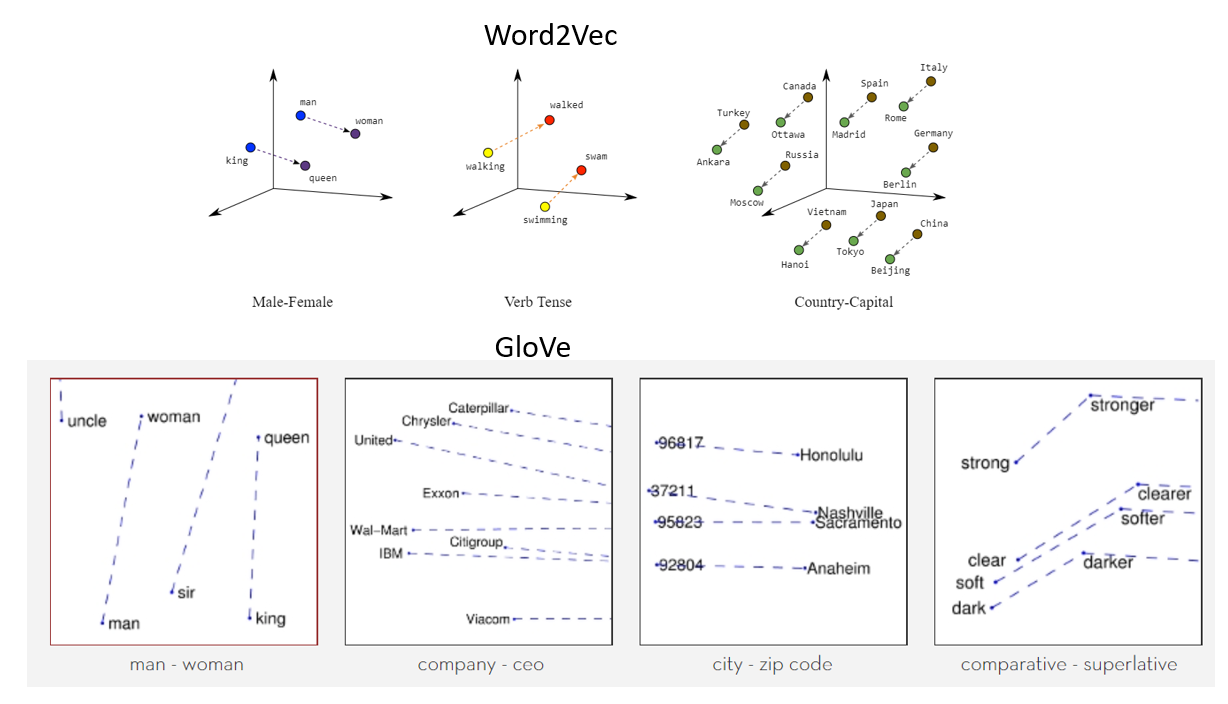
[Source](https://towardsdatascience.com/word-embeddings-for-nlp-5b72991e01d4)

Intuitively words that have similar meanings will be grouped together. As the embedding vectors are learned clusters will form within the vector space. As a result of the embedding space, the network will later be able to measure the 'similarity' or 'disimilarity' of words and use this information to train the model. In the image below we see what an embedding might start to look like when we have many different words forming into clusters within the vector space.




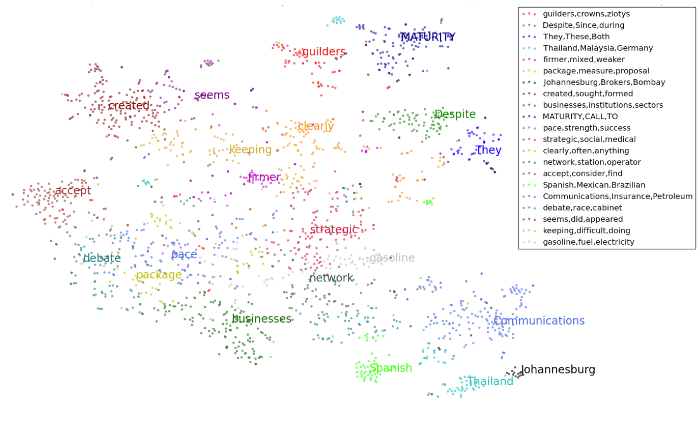
[Source](https://ccri.com/deep-learning-ontology-development/)



There are three main algorithms used to generate word embeddings and you can learn more about this in the article [What are word Embeddings for text?](https://machinelearningmastery.com/what-are-word-embeddings/).
1. Using The Embedding Layer
2. Word 2 Vect
3. GloVe

When using an embedding layer in TensorFlow the weights can be either learned or reused. Learning the weights requires a large amount of text to training and so typically the option of reusing weights from one of the above algorithms is used. 

Reuising weights is similar to the idea of transfer learning because we learn the weights once and can reuse them in any model. When we reuse weights we already have a vector representation for many of the words in our vocabulary, and when training will only need to learn representations of a small number of words.

<a id="pretrained-embeddings"></a>
## Using pretrained embeddings
In order to use a pretrained embedding we will need to adapt the embedding for the vocabulary of the task. The general process is as follows:
1. Download the embeddings text file and convert it into a dictionary wher the key is a word, and the value is the vector representation of the word.
2. Not all words in our voacbulary are found in the embeddings file. We add them to the embeddings dictionary with random values centred around the mean and standard deviation of all the embeddings weights.
3. Point the `tf.keras.layers.Embeddings` layer in our model to the newly generated embeddings matrix. We set `trainable=True` to allow the model to learn embeddings for words outside the pretrained embeddings, and to refine pretrained embeddings to our problem set.

In [ ]:
EMBEDDING_FILE = '../input/glove-global-vectors-for-word-representation/glove.6B.50d.txt'

embeddings_index = dict()

#open the embedding file
f = open(EMBEDDING_FILE)

#load values into the embeddings_index dictionary filtering for words not in corpus
for line in f:
    values=line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float')
    embeddings_index[word] = coefs
f.close()

# get the mean and standard deviation of the embeddings weights
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

#add the missing words to the embeddings and generate the random values
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [ ]:
print(f"Maximum sequence length: {maxlen}")
print(f"Number of words in the embedding: {max_features}")
print(f"Number of words in the vocabulary: {len(tokenizer.word_index)}")
print(f"Number of features per embedding: {embed_size}")

<a id="sequential-layers"></a>
# Sequential Layers

Recrusive Neural Network (RNN) are good for sequental data like that seen in NLP. RNNs can be considered as a typical feed forward network that takes the output of a neuron and loops it back as input. It does this through the hidden state output.

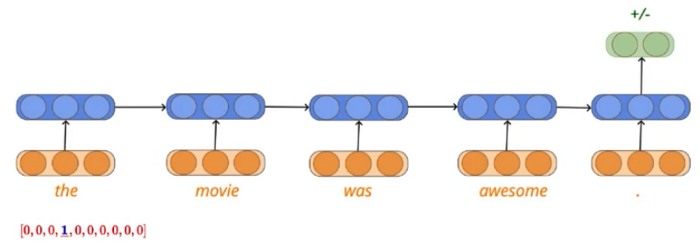
[Source](https://towardsdatascience.com/recurrent-neural-networks-rnn-explained-the-eli5-way-3956887e8b75)

RNNs can be implented in the TensorFlow API using the `tf.keras.layers.RNN` layer. However they have a primary  shortcoming, namely:
- On long input sequences weights might not update because of the vanishing gradient problem.
- As a result of vanishing gradients, RNNs perform well on short inputs, but fail to learn effectively on long inputs i.e. they only have "short-memory"

For more information about RNNs and how they work the article [Illustradted Guide to Recurrent Nerual Networks](https://towardsdatascience.com/illustrated-guide-to-recurrent-neural-networks-79e5eb8049c9) is a great reference.


<a id="gru-lstm"></a>
## GRU & LSTM

Gated recursive Units (GRU) and Long-Short Term Memory (LSTM) are two solutions the help learn form both short- and long-term inputs. They are a variation on the RNN cell architecture that use internal gates within the cell to control the flow of information. The gates learn to distinguish relevant information from non relevant and in this way maintain state information of the input vector even when the sequence is long. The article [Illustrated Guide to LSTM’s and GRU’s: A step by step explanation] does a great job describing how input, forget, output gates (in the case of LSTM), reset, and update gates (GRU).

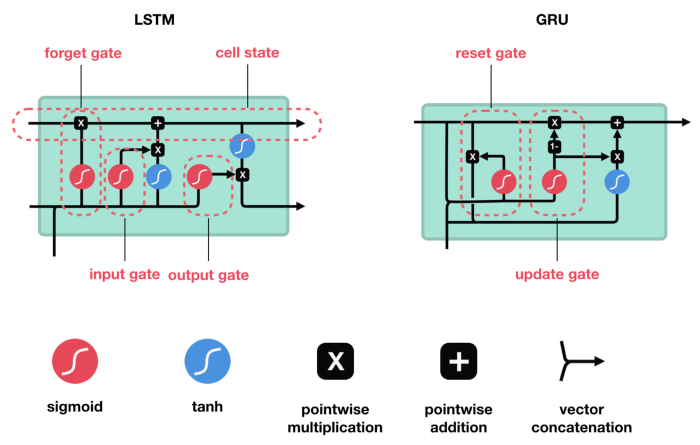
[Source](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)

These layers can be implemented with the [`tf.keras.layers.LSTM`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) and [`tf.keras.layers.GRU`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) layers. They have several parameters of interest, the most relevant being the `return_sequences` parameter. This allows us to chain several LSTM/GRU layers together by returning the embedding from the layer as inputs to the next.

The layers also have several regularization parameters that allow us to apply dropout or weight decay at specific points within the cell.

|Regularization Parameter| Applies To |
|--|--|
|`dropout`|units in input|
|`recurrent_dropout`|units in recurrent state|
| `kernel_regularizer` | weights matrix |
| `recurrent_regularizer` | recurrent kernel weigths |
| `bias_regularizer` | bias vector |
| `activity_regularizer` | output layer |

<a id="bidirectional"></a>
## Bidirectional
Bidirectional layers allow the model to run a recurrent layer forward and backward. The idea is that by learning from sequences both forward and backwards the layer maximizes information gain from the sample. Using this layer assumes that the whole sequence is available to training, and should be used according to the usecase.

The `tf.keras.layers.Bidirectional` layer is a wrapper for the `go_backwards = True` parmeter available in RNN/GRU/LSTM layers. The wrapper creates two layers that are side by side. The two layers run in parallel with one for the layer going forward, a second with the layer going backward and then a merge step that combines the two results.

The `merge_mode` allows us to configure how we combine the forward and backward passes on the sequence layer with several options.

- ‘sum’: Outputs are added together.
- ‘mul’: Outputs are multiplied together.
- ‘concat’: Outputs are concatenated together (the default). This provids double the number of outputs to the next layer.
- ‘ave’: Averages outputs. 

In [ ]:
def sequence_model(maxlen,
                   max_features,
                   embed_size,
                   embedding_matrix,
                   metrics):
    
    tf.keras.backend.clear_session()
    
    if embedding_matrix is not None:
        embeddings = [embedding_matrix]
        output_dim = embedding_matrix.shape[1]
    else:
        embeddings = None
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=maxlen),
        tf.keras.layers.Embedding(max_features, 
                                  embed_size, 
                                  weights=[embedding_matrix], 
                                  trainable=True),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(27, activation='relu', return_sequences = True)),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    optimizer = tf.keras.optimizers.Adam(lr=0.00008, epsilon=0.01)
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)
    
    return model

In [ ]:
METRICS = [
    tf.keras.metrics.AUC(name='roc-auc'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name="recall")
          ]
model = sequence_model(maxlen, max_features, embed_size, embedding_matrix, METRICS)
hist = model.fit(X_balance, Y_balance, epochs=50, batch_size=64, validation_data=(X_val, Y_val))

In [ ]:
def plot(history, *metrics):
    
    n_plots = len(metrics)
    
    fig, axs = plt.subplots(1,n_plots, figsize=(18, 5))

    hist = history.history

    for ax, metric in zip(axs, metrics):
        ax.plot(np.clip(hist[metric], 0, 1))
        ax.plot(np.clip(hist["val_"+metric], 0, 1))
        ax.legend([metric, "val_" + metric])
        ax.set_title(metric)

In [ ]:
plot(hist, 'loss', 'roc-auc', 'accuracy', 'precision', "recall")

# Make Predictions

In [ ]:
test.head()

In [ ]:
X_test = tokenizer.texts_to_sequences(test.question_text)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen, padding='post', truncating='post')

preds = model.predict_classes(X_test)

ss_predictions = ss.copy()
ss_predictions['prediction'] = preds

In [ ]:
ss_predictions.to_csv("submission.csv", index=False)

# Summary

This notebook developed a simple model for classifying sentences as genuine or insincere. To accomplish this task it looked at creating a numerical representation of the text using the TensorFlow `Tokenizer` object. To enhance the model we looked at how to add a pretrained Embedding layer to the model. FInally we trained and evaluated a Bidrectional LSTM model.